Katleho Mokhele 

92124914

## Introduction
### Spam Filter - Model Engineering Task 3

Presented in this notebook is the end-to-end developement of a spam filter that classifies messages as "spam" or "ham". This task forms part of the DLBDSME01 Model Engineering case study.

We will:
- Clean and analyze the dataset
- Build a classification model
- Adjust risk thresholds for filtering
- Propose a deployment strategy via GUI

## Load Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

## Load and Preview Dataset

In [2]:
df = pd.read_csv("../data/SMSSpamCollection.csv", sep='\t', names=["label","text"])
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df[df['label'] == 'spam']

,label,text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


## Clean and Prepare Text

We'll perform standard NLP cleaning:
- Lowercase conversion
- Punctuation removal
- Link and digit removal

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

df['text_clean'] = df['text'].apply(clean_text)
df.head()

,label,text,text_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


## Dataset Exploration

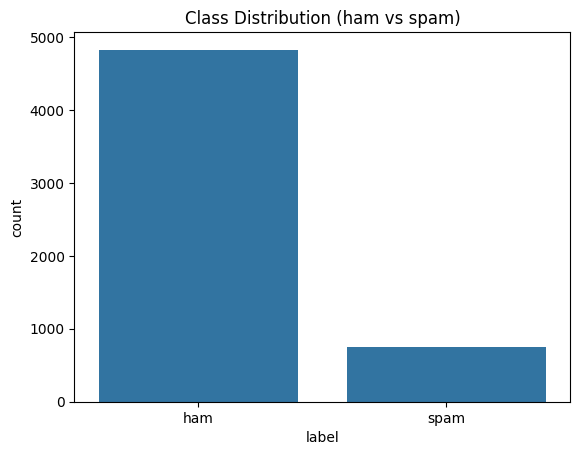

In [5]:
sns.countplot(x='label', data=df)
plt.title("Class Distribution (ham vs spam)")
plt.show()

## WordCloud Visualizations

Visualizing common words in spam and ham messages.

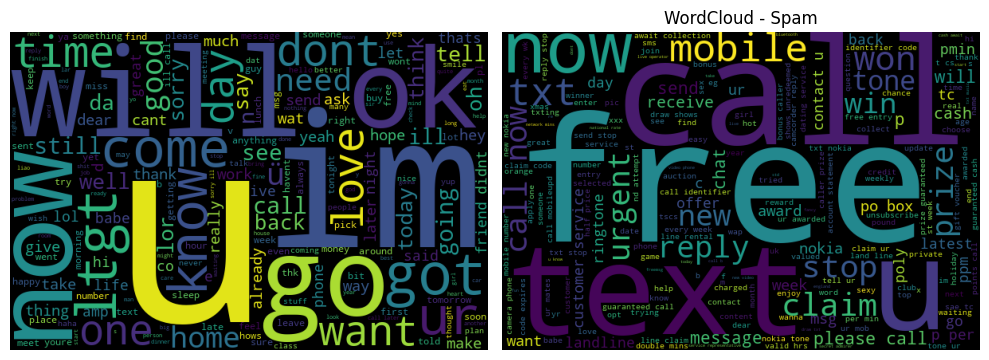

In [6]:
ham_words = ' '.join(df[df['label'] == 'ham']['text_clean'])
spam_words = ' '.join(df[df['label'] == 'spam']['text_clean'])

plt.figure(figsize=(10, 5))
plt.subplot(1,2, 1)
plt.imshow(WordCloud(width=600, height=400).generate(ham_words))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=600, height=400).generate(spam_words))
plt.axis('off')
plt.title("WordCloud - Spam")

plt.tight_layout()
plt.show()

## TF-IDF Vectorization

We convert the cleaned text into numerical format using TF-IDF.

In [7]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text_clean'])
y = df['label'].map({'ham': 0, 'spam': 1})

## Train-Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train Logistic Regression Model
### Model Training
We use Logistic Regression due to its simplicity, speed, and interpretability.

In [9]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Model Evaluation

We evaluate performance using accuracy , F1 score, and confusion matrix.

In [10]:
y_pred = model.predict(X_test)
print("classification_report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

classification_report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.70      0.83       149

    accuracy                           0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115

Confusion Matrix:
 [[966   0]
 [ 44 105]]


In [11]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (Spam): {f1:.4f}")

Accuracy: 0.9605
F1 Score (Spam): 0.8268


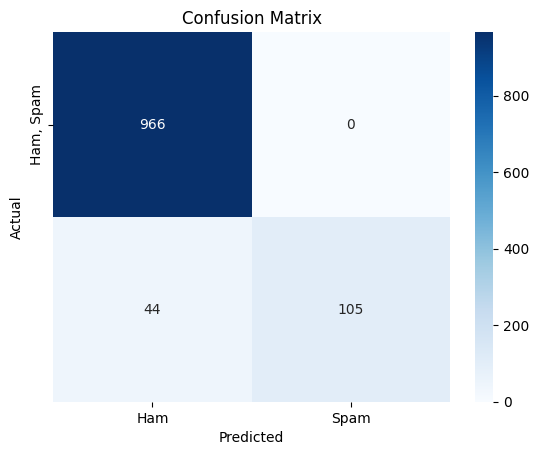

In [12]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham, Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Risk Threshold filtering

We allow the service team to set risk thresholds:
- High risk (0.5): Lenient, accepts more false positives
- Medium Risk (0.7)
- Low Risk (0.9): Strict, blocks borderline messages

In [13]:
def classify_with_threshold(text, threshold=0.5):
    cleaned =clean_text(text)
    vect = vectorizer.transform([cleaned])
    prob = model.predict_proba(vect)[0][1]
    return ("spam", prob) if prob >= threshold else ("ham", prob)

## Test Predictions at different Thresholds

In [14]:
sample_msg = "Congratulations! You have won a $1000 gift card. Reply WIN now."
for level, threshold in [('Low Risk (0.9)', 0.9), ('Medium Risk (0.7)', 0.7), ('High Risk (0.5)', 0.5)]:
    label, prob = classify_with_threshold(sample_msg, threshold)
    print(f"{level} => Predicted: {label} (Confidence: {prob: .2f})")

Low Risk (0.9) => Predicted: ham (Confidence:  0.79)
Medium Risk (0.7) => Predicted: spam (Confidence:  0.79)
High Risk (0.5) => Predicted: spam (Confidence:  0.79)


## Coclusion & Integration Proposal

The Logistic Regression spam filter achieves:
- **Accuracy**: ~96%
- **F1 Score (Spam)**: ~0.83
- Handles varying business needs through **adjustable risk levels**

---

## Integration Plan

We propose deploying this model using a simple GUI built with  **Streamlit** that allows users to:

- Paste an SMS message
- Select spam risk level
- View results with confidence

Border messages (e.g., between 0.5-0.9 confidence) can be sent to a **manual review queue**.

A retrianing mechanism can be added to periodically improve performance using misclassified examples.